# Introduction to Boosting

-----

The [decision tree][wdt] is one of the simplest machine learning algorithms to understand. Simple to develop and easy to apply, they quickly became a popular machine learning tool. However, they can be prone to overfitting the data, especially when they become too large. As a result, ensemble techniques were developed that combined the predictions from many decision trees, that in general are small and might be trained only on a fraction of the data, to make a more powerful meta-estimator. 

In the _Introduction to Bagging_ notebook, we explored the concept of bagging, which can be used to construct one type of ensemble estimator. Bagging employs bootstrap aggregation to first create samples of the original data set, which are each used to construct a weak learner, generally by using a decision tree. Finally, these weak learners are aggregated together to make a more powerful predictor.

In this notebook, we introduce a second approach, known as [boosting][wb], where many weak learners, for example, very shallow decision trees (also known as _tree stumps_), are trained. The predictions from these weak learners are combined together, for example, by majority voting, and the results are used to generate weights for the input training data. These weights are used by the boosting algorithm to emphasize instances that are incorrectly predicted, and to deemphasize instances that are correctly predicted. This process continues iteratively, during which the weak learners eventually become more accurate.

In this IPython Notebook, we introduce two algorithms that implement boosting: Gradient Tree Boosting and Adaboost. For space considerations, we focus most of the notebook on effectively using Gradient Boosted Trees (GBT). First, we demonstrate this algorithm on the Iris classification task, which also allows us to demonstrate how this algorithm can be used to compute feature importances, as well as use decision surfaces to explore different hyperparameters. Next, we apply this algorithm to a more challenging classification and regression data set, which allow the concepts of _staged prediction_ and _partial dependence_ to be introduced. Finally, the Adaboost algorithm is quickly presented by applying it to these same data sets.

Throughout this notebook, you should think about how these results from boosting are different than the results from the other algorithms, in particular the bagging algorithms introduced in a different notebook. You also should explore how changes in the default hyperparameter values affect the performance of this algorithm.

-----
[wb]: https://en.wikipedia.org/wiki/Boosting_(machine_learning)
[wdt]: https://en.wikipedia.org/wiki/Decision_tree

## Table of Contents

[Formalism](#Formalism)

[Gradient Tree Boosting: Classification](#Gradient-Tree-Boosting:-Classification)

- [Classification: Iris Data](#Classification:-Iris-Data)
- [Gradient Tree Boosting: Decision Surface](#Gradient-Tree-Boosting:-Decision-Surface)
- [Gradient Tree Boosting: Hyperparameters](#Gradient-Tree-Boosting:-Hyperparameters)
- [Gradient Tree Boosting: Feature Importance](#Gradient-Tree-Boosting:-Feature-Importance)
- [Classification: Adult Data](#Classification:-Adult-Data)
- [Gradient Tree Boosting: Staged Predictions](#Gradient-Tree-Boosting:-Staged-Predictions)


[Gradient Tree Boosting: Regression](#Gradient-Tree-Boosting:-Regression)

- [Regression: Auto MPG Data](#Regression:-Auto-MPG-Data)
- [Gradient Tree Boosting: Partial Dependence](#Gradient-Tree-Boosting:-Partial-Dependence)

- [Adaboost](#Adaboost)

-----

Before proceeding with the _Formalism_ section of this Notebook, we first have our standard notebook setup code.

-----



In [1]:
# Set up Notebook
% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_style('white')

-----

[[Back to TOC]](#Table-of-Contents)

## Formalism

While there are a number of different boosting algorithms, the scikit learn library includes two of the more popular ones: the [Adaboost][wa] algorithm, which is short for adaptive boosting, and the [Gradient Tree Boosting][wgtb] algorithm, both in the `ensemble` module. The Adaboost algorithm works as the earlier boosting description outlined. Weights are generated in each iteration and used to improve the overall prediction of the aggregated weak learners. The Gradient Tree Boosting algorithm extends this to support arbitrary [cost (or loss)][sklf] functions, beyond the minimization of the deviation between predicted and actual labels (classification), or least squares (regression).

These two algorithms will both be explored in this notebook, although most of the notebook focuses on the Gradient Tree Boosting, with the Adaboost algorithm presented at the end for comparison purposes. The construction of the individual base learners is based on a permutation of the features when determining the best split. Thus, the individual learners can be different, even if they are constructed by using all of the training data. These and other characteristics of the Gradient Tree Boosting algorithm are controlled by a set of hyperparameters, many of which are the same as for bagging estimators. Some of the more useful hyperparameters include:
- `loss`: the loss function to use, which differs for classification and regression tasks. By default, classification employs `deviance`, which is equivalent to that used for logistic regression, while regression employs least squares.
- `learning_rate`: this controls shrinkage, which controls the impact of each tree on the weight calculation during each iteration, by default the value is one.
- `n_estimators`: the number of individual base learners to use at each iteration, by default this is one hundred.
- `max_depth`: the maximum depth of the shallow trees, by default this is three.
- `subsample`: the fraction of instances to use when fitting individual base learners, default is one or all of the training instances.
- `max_features`: the number of features to examine when determining the best split during tree construction.
- `warm_start`: if `True`, reuse existing model as a starting condition and add new estimators, the default value is `False`. 

-----
[wa]: https://en.wikipedia.org/wiki/AdaBoost
[wgtb]: https://en.wikipedia.org/wiki/Gradient_boosting
[sklf]: http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting-loss

-----

[[Back to TOC]](#Table-of-Contents)

## Gradient Tree Boosting: Classification

We will first employ the gradient tree boosting algorithm to classification tasks. To do this we will use the [`GradientBoostingClassifier`][skgtb] estimator from the scikit-learn `ensemble` module. This estimator will construct, by default, a gradient tree boosting estimator from a training data set. We have already discussed a number of important hyperparameters for this algorithm, but several others not include:

- `criterion`: the method by which to measure the quality of a potential split.
- `min_samples_split`: the minimum number of instances required to split a node into two child nodes, by default this is two.
- `min_samples_leaf`: the minimum number of instances required to make a node terminal (i.e., a leaf node), the default for this value is one.
- `random_state`: the seed for the random number generator used by this estimator. Setting this value ensures reproducibility.
- `init`: an estimator that provides the initial classifications, by default this is provided by the selected _loss_ function.

To demonstrate using a gradient tree boosting estimator with the scikit-learn library, we will first load in the Iris data. With these data, we will construct a `GradientBoostingClassifier` estimator, and demonstrate its efficacy via performance metrics and a decision surface. This will also include a demonstration of the use of a boosting estimator to compute feature importance, and a demonstration of the importance of the algorithmic hyperparameters. Next, this algorithm will be applied to the Adult data for classification and the Auto data for regression. Finally, we will also demonstrate the Adaboost estimator on these same data.

----
[skgtb]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

[[Back to TOC]](#Table-of-Contents)

### Classification:  Iris Data

We can now apply the gradient boosting algorithm to the Iris data to create a classification model. The basic approach is simple, and follows the standard scikit-learn estimator philosophy:

1. Import our estimator, [`GradientBoostingClassifier`][skgtb], from the proper scikit-learn module, `ensemble`.
2. Create the estimator and specify the appropriate hyperparameters. For the gradient tree boosting algorithm, we can accept the defaults, or specify values for specific hyperparameters such as `learning_rate`.
3. Fit the model to the training data, note that by using our simple `get_iris_data` helper function we have loaded the Iris data, split the data into training and testing sets, and scaled all data by first normalizing the training data. Although this last step is not required for tree based ensemble techniques.
4. Predict new classes with our trained model (or in the simple demonstration below, generate a performance metric via the `score` method).

These steps are demonstrated in the following Code cell, where we obtain our data, create our estimator, fit the estimator to our training data, and generate a performance score on the testing data. 

-----
[skgtb]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [2]:
from helper_code import iris as hi

# Amount to hold out for 'blind' testing
test_frac = 0.5

# Show the 'Train' and 'Test' data plot.
show_plot = False

# Split data into training and testing
# Note that we have both 'data' and 'labels'
d_train_sc, d_test_sc, l_train, l_test = \
    hi.get_iris_data(test_frac, show_plot)

In [3]:
from sklearn.ensemble import GradientBoostingClassifier

# First we construct our gradient boosting model, 
# We specify 500 trees to start, each with a maximum 
# depth of three. We also specify the random_state 
# hyperparameter to ensure reproduceability.
gbtc = GradientBoostingClassifier(n_estimators=500, max_depth=3, random_state=23)

# Fit estimator to scaled training data
gbtc = gbtc.fit(d_train_sc, l_train)

# Compute and display accuracy score
score = 100.0 * gbtc.score(d_test_sc, l_test)
print(f"Gradient Boosting prediction accuracy = {score:5.1f}%")

Gradient Boosting prediction accuracy =  94.7%


-----

Notice that, even when using only 50% of the total data for training, our gradient boosting classifier still achieves remarkable accuracy on the testing data. For completeness, we also display the classification report and the confusion matrix in the following two Code cells. The per-class precision and recall are very good, with a minor issue in the prediction of class `Virginica` and `Versicolor`, which is also demonstrated clearly in the confusion matrix.

-----

In [4]:
from sklearn.metrics import classification_report

# Thre types of Iris in data set
labels = ['Setosa', 'Versicolor', 'Virginica']

# Predict on test data and report scores
y_pred = gbtc.predict(d_test_sc)
print(classification_report(l_test, y_pred, \
                            target_names = labels))

             precision    recall  f1-score   support

     Setosa       1.00      1.00      1.00        27
 Versicolor       0.91      0.91      0.91        23
  Virginica       0.92      0.92      0.92        25

avg / total       0.95      0.95      0.95        75



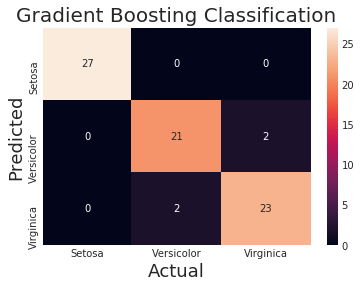

In [5]:
from helper_code import mlplots as ml

# Call confusion matrix plotting routine
ml.confusion(l_test.reshape(l_test.shape[0]), 
             y_pred, labels, 3, 
             'Gradient Boosting Classification')

-----

[[Back to TOC]](#Table-of-Contents)

### Gradient Tree Boosting:  Feature Importance

We can leverage the fact that the gradient tree boosting algorithm builds many weak learners and iteratively improves them to determine the importance of the different features. By default, these values simply encode the importance of a feature, where higher values are more important. We can take the ratio of these values, however, to compute a relative importance. We demonstrate this in the following Code cell, where we extract the feature importances, normalize them by the maximum importance, and display these relative importances for each feature. Note that these results agree with our previous results on the Iris data, for this training data set, only two features: Petal Width and Petal Length, account for most of the importance.

----

In [6]:
# Display feature importance as computed from the GTB

# Feature names
feature_names = ['Sepal Length', 'Sepal Width', 
                 'Petal Length', 'Petal Width']

fi = gbtc.feature_importances_ / np.max(gbtc.feature_importances_)
# Display name and importance
for name, val in zip(feature_names, fi):
    print(f'{name}: relative importance = {100.0*val:5.2f}%')

Sepal Length: relative importance =  9.09%
Sepal Width: relative importance = 25.14%
Petal Length: relative importance = 100.00%
Petal Width: relative importance = 76.43%


-----

[[Back to TOC]](#Table-of-Contents)

### Gradient Tree Boosting:  Decision Surface

We demonstrate the application of a gradient tree boosting algorithm by constructing a decision surface in the following Code cell on a two-dimensional Iris data set feature space. This code employs several helper methods that we have used repeatedly in other notebooks. First, we need to reduce our data set down to two dimensions to make the decision surface visualization. This step is accomplished by the `trim_data` helper function, which takes our training features and labels and returns a two-dimensional array that holds two features: Sepal Width and Petal Width, along with the classification. Next, we generate a two-dimensional mesh grid along these two dimensions. 

We fit a gradient tree boosting classifier to the trimmed two-dimensional data (we could fit on the full data, but in this example we use only the two dimensions used in the plot), and apply to the mesh grid to construct the decision surface. Finally, we generate a scatter plot of the training data and color the underlying mesh appropriately by the predicted class for that cell.

As the decision surface below demonstrates, this default gradient boosting classifier separates the classes cleanly with linear cuts. On the other hand, even though each split generates a linear classification, their combination can be non-linear (note the rectangle cut-out enclosing the single instance).

-----

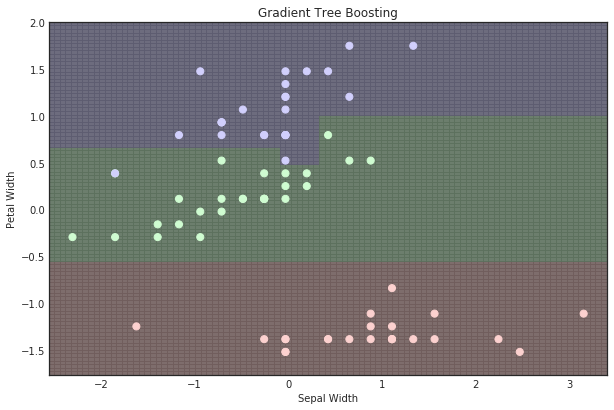

In [7]:
# Make a two-dimensional Iris data set
n_data = hi.trim_data(d_train_sc, l_train)

# Construct mesh grid data
mdata = hi.get_mdata(n_data)

fig, ax = plt.subplots(figsize=(10,8))

# Now train our model
gbtc.fit(n_data[:,:2], n_data[:,2])
    
# Predict for mesh grid
z = gbtc.predict(mdata)
    
# Plot training data and mesh grid
hi.splot_data(ax, n_data, mdata, z,
              'Sepal Width', 'Petal Width', 50)
    
ax.set_title(f'Gradient Tree Boosting') ;

-----

[[Back to TOC]](#Table-of-Contents)

### Gradient Tree Boosting: Hyperparameters

While a partial list of the hyperparameters that are available to use with the [GradientBoostingClassifier][skgtb] were presented earlier in this notebook, the full set is available from the estimator's online documentation. Of these hyperparameters, the effect of some are easier to understand, such as the `max_depth`, which limits how many split levels a tree can be used to build a tree. To fully understand the impact of a hyperparameter, beyond simply computing the performance metrics for different values, we can construct and compare decisions surfaces for different values of a particular hyperparameter.

In the following Code cell, we generate three different decision surfaces, corresponding to three different values of the `n_estimators` hyperparameter: 10, 50, and 100. As the following figures demonstrate, the first decision surface is rather simple with several linear cuts. The second decision surface is more complex, and actually encloses all test data correctly. Finally, the final figure matches the decision surface for our original decision tree classifier, which is not surprising since `100` is the default value for this hyperparameter. Note, in this case the base tree learners are only splitting on these two features. 

----

[skgtb]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

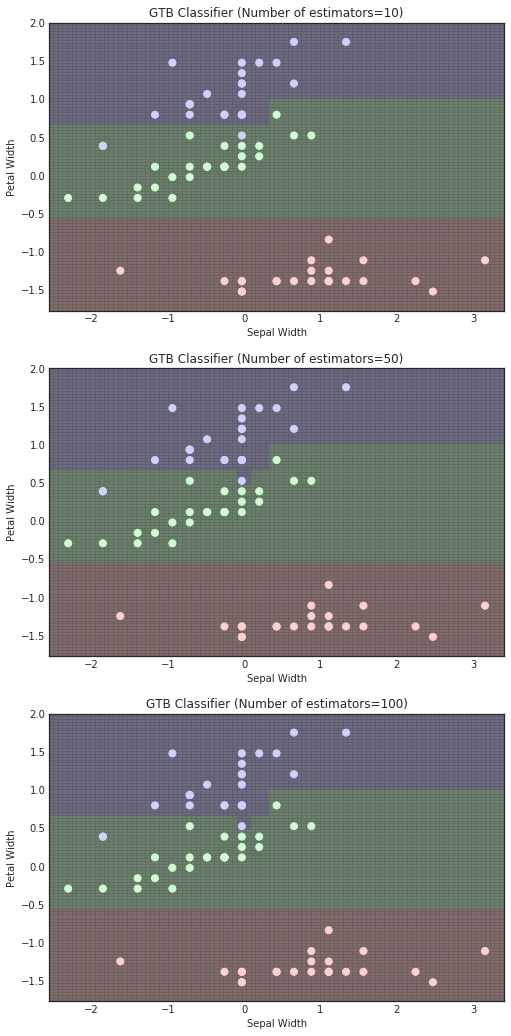

In [8]:
num_tree = [10, 50, 100]

# Show the mesh grid and training data
fig, axs = plt.subplots(figsize=(10, 6 * len(num_tree)), 
                        nrows=len(num_tree), ncols=1, 
                        sharex=False)

# Iterate through different neighbor counts
for idx, nt in enumerate(num_tree):
    
    # Now train our model
    gbtc.set_params(n_estimators=nt, random_state=23)
    
    # Now train our model
    gbtc.fit(n_data[:,:2], n_data[:,2])
    
    # Predict for mesh grid
    z = gbtc.predict(mdata)
    
    # Plot training data and mesh grid
    hi.splot_data(axs[idx], n_data, mdata, z, 
                  'Sepal Width', 'Petal Width', 50)
    
    axs[idx].set_title(f'GTB Classifier (Number of estimators={nt})')

-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cell, we generated decision surfaces for three different values of the `n_estimators` hyperparameter. In the previous Code cell, try making the following changes and think about what you can learn from the new decision surfaces. 

2. Change the values of `max_depth` to 4, 6, and 8.
3. Try exploring a different hyperparameter, such as changing the `learning_rate` to values between zero and one.

-----

-----

[[Back to TOC]](#Table-of-Contents)

## Classification: Adult Data

We now turn to a more complex data set with which to perform classification, by using a boosting ensemble classifier. The data we will explore next is the [Adult income prediction task][uciad]. These data have been analyzed in other notebooks, so we will not go into detail here. The first two Code cells below check to see if the data exist locally, and if not, pulls the data by using the `wget` command. The third Code cell reads this data file in and creates a binary label array for the salary column (i.e., high salary or low salary), along with a number of columns in a features array. Finally, several instances are sampled from the features array to demonstrate the data that will be used for classification.

-----
[uciad]: https://archive.ics.uci.edu/ml/datasets/Adult

In [9]:
# Adult data file from UCI ML Repository
# http://archive.ics.uci.edu/ml/machine-learning-databases/adult/

# First we find our HOME directory
tmp = !echo $HOME

# Second we construct the full path, below our 
# HOME directory to file location
data_file=tmp[0] + '/work/data/adult.data'

In [10]:
%%bash -s "$data_file"

# Note, we passed in a Python variable above to the Bash script 
# which is then accessed via positional parameter, or $1 in this case.

# First test if file of interest does not exist
if [ ! -f "$1" ] ; then

# If it does not exist, we grab the file from the Internet and
# store it locally in the data directory

wget -O "$1" http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

else
    
    echo "File already exists locally."
fi

File already exists locally.


In [11]:
# Adult data archived at UCI ML Repository
col_names = ['Age', 'Workclass', 'FNLWGT', 'Education', 
             'EducationLevel', 'MaritalStatus', 'Occupation', 
             'Relationship', 'Race', 'Sex', 'CapitalGain', 'CapitalLoss', 
             'HoursPerWeek', 'NativeCountry', 'Salary']

# Read CSV data into DataFrame
adult_data = pd.read_csv(data_file, index_col=False, names = col_names)

# Create label column, one for >50K, zero otherwise.
adult_data['Label'] = adult_data['Salary'].map(lambda x : 1 if '>50K' in x else 0)

# Now we can drop the original column
adult_data = adult_data.drop('Salary', axis=1)

# Generate categorical features
categorical = ['Education', 'Workclass', 'Race', 'Sex', 
               'Occupation', 'Relationship', 'NativeCountry']
cat_data = pd.get_dummies(adult_data[categorical])

# Extract numerical features
numerical = ['Age', 'EducationLevel', 'HoursPerWeek', 
             'CapitalGain', 'CapitalLoss']
num_data = adult_data[numerical]

# Generate our labels
labels = adult_data['Label']

# Combine categorical and numerical data into features
features = pd.concat([num_data, cat_data], axis=1)
features.sample(5)

,Age,EducationLevel,HoursPerWeek,CapitalGain,CapitalLoss,Education_ 10th,Education_ 11th,Education_ 12th,Education_ 1st-4th,Education_ 5th-6th,...,NativeCountry_ Portugal,NativeCountry_ Puerto-Rico,NativeCountry_ Scotland,NativeCountry_ South,NativeCountry_ Taiwan,NativeCountry_ Thailand,NativeCountry_ Trinadad&Tobago,NativeCountry_ United-States,NativeCountry_ Vietnam,NativeCountry_ Yugoslavia
14636,41,9,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
17089,21,9,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8205,38,13,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4139,29,9,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11026,28,13,60,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


-----

With our feature and label data prepared, we are now ready to begin the machine learning process. In the following two Code cells we first create our gradient tree boosting classifier, and measure its performance on our training data. In the first Code cell, we start by splitting our data into training and testing samples. Since we have over 30,000 instances in our data set, we employ a more stringent 50%:50% split. Next, we create the `GradientBoostingClassifier` estimator. The only hyperparameter that we specify at this time is  `random_state` in order to ensure reproducibility. Next, we fit this estimator to our training data, and generate an accuracy score on our test data. 

In the second Code cell, we compute and display a simple accuracy score before generating and displaying the full classification report. Note that even with this simple approach, our boosting classifier performs well, easily beating the zero-model demonstrated in the _Introduction to Bagging_ notebook. In addition, the report indicates that our model performs worst in predicting the positive class, which is often the case with an unbalanced data set. By judiciously selecting hyperparameters, or stratifying the training and testing data, this class-based performance can be improved.


----

In [12]:
from sklearn.model_selection import train_test_split

frac = 0.5
d_train, d_test, l_train, l_test = \
    train_test_split(features, labels,
                     test_size=frac, random_state=23)

adult_model = GradientBoostingClassifier(random_state=23)

adult_model = adult_model.fit(d_train, l_train)

In [13]:
from sklearn import metrics

# Classify test data and display score and report
predicted = adult_model.predict(d_test)
score = 100.0 * metrics.accuracy_score(l_test, predicted)
print(f'Gradient Tree Boosting Classification [Adult Data] Score = {score:4.1f}%\n')
print('Classification Report:\n {0}\n'.format(
    metrics.classification_report(l_test, predicted)))

Gradient Tree Boosting Classification [Adult Data] Score = 86.4%

Classification Report:
              precision    recall  f1-score   support

          0       0.88      0.95      0.91     12298
          1       0.80      0.60      0.68      3983

avg / total       0.86      0.86      0.86     16281




-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cells, we constructed a gradient tree boosting classification estimator and applied it to the adult income prediction task. The initial result was reasonable, but try making the following changes to see if you can do better.

2. Change the features used in the classification, for example drop one or more columns, such as native country. Do the results change? 
3. Try using different hyperparameter values, such as `n_features`, `learning_rate`, or `max_features`.
4. Try setting the `stratify` hyperparameter for the `train_test_split` method to ensure balanced class representation in the training and testing data sets.

-----

[[Back to TOC]](#Table-of-Contents)


## Gradient Tree Boosting: Staged Predictions

We can use the [`staged_predict`][spsk] method in scikit learn to analyze the change in the accuracy of the gradient tree boosting classifier on these data as new estimators are created. This method provides access to the individual estimators, thus we can compute a metric to quantify our accuracy as the GBT progresses to the final estimator. In this case, we only plot about half of the total estimators created since the remainder do not change the accuracy of the estimator. Note that the following code displays the [`accuracy_score`][assk], but other metrics such as the [`f1_score`][f1sk] or the [`mean_absolute_error`][maesk] could also be used.

The generated figure demonstrates that the accuracy for the test data closely matches that for the training data. This is not surprising since we held out half of the data (by default) for testing, thus we expect the testing and training data to span roughly the same parameter space. In addition, the curves quickly reach an asymptotic limit, by approximately twenty estimators the curves level off. This suggests that increasing the number of estimators (while holding the other hyperparameters constant) is unlikely to significantly improve the accuracy.

-----
[spsk]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.staged_predict
[assk]: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
[f1sk]: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
[maesk]: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

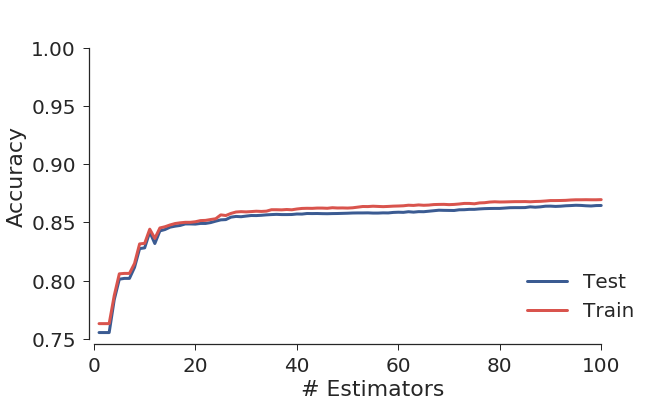

In [14]:
# We could plot different metrics, we choose accuracy_score for its genericity
from sklearn.metrics import accuracy_score
from sklearn.ensemble.gradient_boosting import predict_stages

# Grab number of estimators (by default this will be 100)
n_est = len(adult_model.estimators_)

# Create arrays to hold accuracy scores
dev_test = np.zeros(n_est)
dev_train = np.zeros(n_est)

# Apply each estimator to the testing and training data
for idx, y_pred in enumerate(adult_model.staged_predict(d_test)):
    dev_test[idx] = accuracy_score(l_test, y_pred)

# compute the accuracy score for each stage
for idx, y_pred in enumerate(adult_model.staged_predict(d_train)):
    dev_train[idx] = accuracy_score(l_train, y_pred)

# Plot the results
sns.set(style="white")
sns.set(style="ticks", font_scale=2.0)
fig, ax = plt.subplots(figsize=(10,6))
         
# Plot testing data results
ax.plot(np.arange(n_est) + 1, dev_test, 
        color=sns.xkcd_rgb["denim blue"], 
        label='Test', lw=3)

# Plot training data results
ax.plot(np.arange(n_est) + 1, dev_train, 
        color=sns.xkcd_rgb["pale red"], 
        label='Train', lw=3)

# Decorate figure
ax.set_ylabel('Accuracy')
ax.set_xlabel('# Estimators')
ax.set_ylim((0.75, 1.03))
ax.set_xlim((0, 110))
ax.legend(loc=4)

sns.set(style="ticks", font_scale=2.0)
sns.despine(offset=5, trim=True)

-----

[[Back to TOC]](#Table-of-Contents)

## Gradient Tree Boosting: Regression

We can also use gradient boosting to perform regression; however, in this case we attempt to create trees whose leaf nodes contain data that are nearby in the overall feature space. To predict a continuous value from a tree, we either have leaf nodes with only one feature, and use the relevant feature from that instance as our predictor, or we compute summary statistics from the instances in the appropriate leaf node, such as the mean or mode. The boosting algorithm combines these predictions together to (hopefully) make a more accurate estimator.

To perform regression with the scikit-learn library we employ the [`GradientBoostingRegressor`][skgtb] estimator in the `ensemble` module. This estimator employs the same set of hyperparameters as the `GradientBoostingClassifier` estimator, and is, therefore, used in a similar manner. One point, which was also true for classification, by specifying the `random_state` hyperparameter, we ensure reproducibility. This is because every time trees are constructed for the gradient boosting algorithm, the features are randomly permuted at every split. Thus, even if we use the same set of hyperparameters and the same set of training data, we can end up with different trees if the `random_state` hyperparameter is not fixed.

In this section, we employ gradient tree boosting to perform regression for the automotive fuel performance prediction. First, we will introduce these data, and prepare them for the regression task. We will employ the patsy module to use a regression formula to create our dependent and independent feature matrices. Finally, we will construct our boosting estimator, apply it on these data, and evaluate its performance.

-----

[skgtb]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

[[Back to TOC]](#Table-of-Contents)

### Regression: Auto MPG Data

The [automobile fuel performance prediction data][uciap] were collated by Ross Quinlan and released in 1993. We have used these data multiple times in other notebooks, thus we will instead focus on the application of a boosting estimator for regression. The first two Code cells check if the data are stored locally, and if not use the `wget` command to pull the data from the UCI ML repository. The third Code cell extracts the dependent feature and the independent features as arrays for use in our regression model.

----
[uciap]: https://archive.ics.uci.edu/ml/datasets/auto+mpg

In [15]:
# Auto MPG data file from UCI ML Repository
# https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/

# Second we construct the full path, below our 
# HOME directory to file location
data_file=tmp[0] + '/work/data/auto-mpg.data'

In [16]:
%%bash -s "$data_file"

# Note, we passed in a Python variable above to the Bash script 
# which is then accessed via positional parameter, or $1 in this case.

# First test if file of interest does not exist
if [ ! -f "$1" ] ; then

# If it does not exist, we grab the file from the Internet and
# store it locally in the data directory

wget -O "$1" https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

else
    
    echo "File already exists locally."
fi

File already exists locally.


In [17]:
import patsy as pts 

# Names for our columns
col_names = ['MPG', 'Cylinders', 'Displacement',
             'Horsepower', 'Weight', 'Acceleration', 
             'Year', 'Origin', 'Name']

# Create DataFrame and sample the result
auto_data = pd.read_csv(data_file, index_col=False, names = col_names, 
                  delim_whitespace=True)

# Create independent and dependent arrays
y, x = pts.dmatrices('MPG ~ C(Cylinders) + Displacement + ' +
                     'Weight + Acceleration + C(Year) + C(Origin)', 
                     data=auto_data, return_type='dataframe')

# randomly sample features
x.sample(5)

,Intercept,C(Cylinders)[T.4],C(Cylinders)[T.5],C(Cylinders)[T.6],C(Cylinders)[T.8],C(Year)[T.71],C(Year)[T.72],C(Year)[T.73],C(Year)[T.74],C(Year)[T.75],...,C(Year)[T.78],C(Year)[T.79],C(Year)[T.80],C(Year)[T.81],C(Year)[T.82],C(Origin)[T.2],C(Origin)[T.3],Displacement,Weight,Acceleration
167,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,97.0,2171.0,16.0
43,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400.0,4746.0,12.0
113,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155.0,2472.0,14.0
70,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400.0,4422.0,12.5
115,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,350.0,4082.0,13.0


-----

With these two DataFrames, we can now build a regressive model. First, we import the `GradientBoostingRegressor` before splitting our independent and dependent variables into training and testing samples. Next, we create our estimator, specifying a value for our `random_state` hyperparameter to enable reproducibility. Finally, we fit the model and display a predictive score. The second Code cell computes a number of different regression performance metrics and displays the results. Notice that, even with no hyperparameter tuning, the performance exceeds the performance of simple algorithms like the decision tree. This is generally the case with ensemble techniques, which also have the benefit of being less affected by overfitting.

The gradient tree boosting algorithm can support regression on multiple outputs, in the same manner as the random forest regressor. To generate regression model for a multi-output data set, simply pass in the two-dimensional label array to the `GradientBoostingRegressor` estimator.

-----

In [18]:
from sklearn.ensemble import GradientBoostingRegressor

# Split data intro training:testing data set
ind_train, ind_test, dep_train, dep_test = \
    train_test_split(x, y, test_size=frac, random_state=23)

# Create Regressor with default properties
auto_model = GradientBoostingRegressor(random_state=23)

# Fit estimator and display score
auto_model = auto_model.fit(ind_train, dep_train)
print('Score = {:.1%}'.format(auto_model.score(ind_test, dep_test)))

Score = 81.7%


In [19]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

# Regress on test data
pred = auto_model.predict(ind_test)

# Copute performance metrics
mae = mean_absolute_error(dep_test, pred)
mse = mean_squared_error(dep_test, pred)
mbe = median_absolute_error(dep_test, pred)
mr2 = r2_score(dep_test, pred)

ev_score = explained_variance_score(dep_test, pred)

# Display metrics
print(f'Mean Absolute Error   = {mae:4.2f}')
print(f'Mean Squared Error    = {mse:4.2f}')
print(f'Median Absolute Error = {mbe:4.2f}')
print(f'R^2 Score             = {mr2:5.3f}')
print(f'Explained Variance    = {ev_score:5.3f}')

Mean Absolute Error   = 2.25
Mean Squared Error    = 10.50
Median Absolute Error = 1.51
R^2 Score             = 0.817
Explained Variance    = 0.819


-----

<font color='red' size = '5'> Student Exercise </font>

In the previous Code cells, we constructed a gradient tree boosting regression model for the automobile fuel performance prediction task. The initial result was reasonable, but try making the following changes to see if you can do better.

2. Change the features used in the regression, for example drop one column, such as `origin`. Do the results change? 
3. Try using different hyperparameter values, such as changing the `loss` function, `n_estimators`, `learning_rate`, or `subsample`.

-----

[[Back to TOC]](#Table-of-Contents)

## Gradient Tree Boosting: Partial Dependence

The feature importance shown earlier provides an indication of the relative importance of the different features, for either classification or regression. An alternate approach to understanding the relationship between features and their importance involves the construction of [_partial dependence_][pd] plots. These plots show the dependence between the regression model and a specific set of features, selected from the set of all features used to build the regression model. To calculate this dependence, we marginalize over all of the other features, so that the effect of the target feature (or features) is measured. Generally, this set is restricted to a small number, such as one or two, since it becomes hard to visualize larger relationships.

The scikit learn library provides two functions that can produce partial dependence plots from gradient tree boosting estimators. In the Code cell below, we generate three one-dimensional partial dependence plots for the `Displacement`, `Weight`,  and `Acceleration` features, by using the [`partial_dependence`][skpd] function in the scikit-learn library. From the resulting figures, we see that there is an inverse linear relationship between both the `Displacement` and `Weight` features and the target feature, which is fuel efficiency. This makes sense, heavier cars consume more fuel, and cars that have larger engines (displacement) consume more fuel. On the other hand, acceleration is fairly flat in impacting the target feature, except for very low values. This likely results from the fact that slow accelerations consume less fuel, but at some point this saturates and becomes unimportant.

-----

[pd]: http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html
[skpd]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.partial_dependence.partial_dependence.html

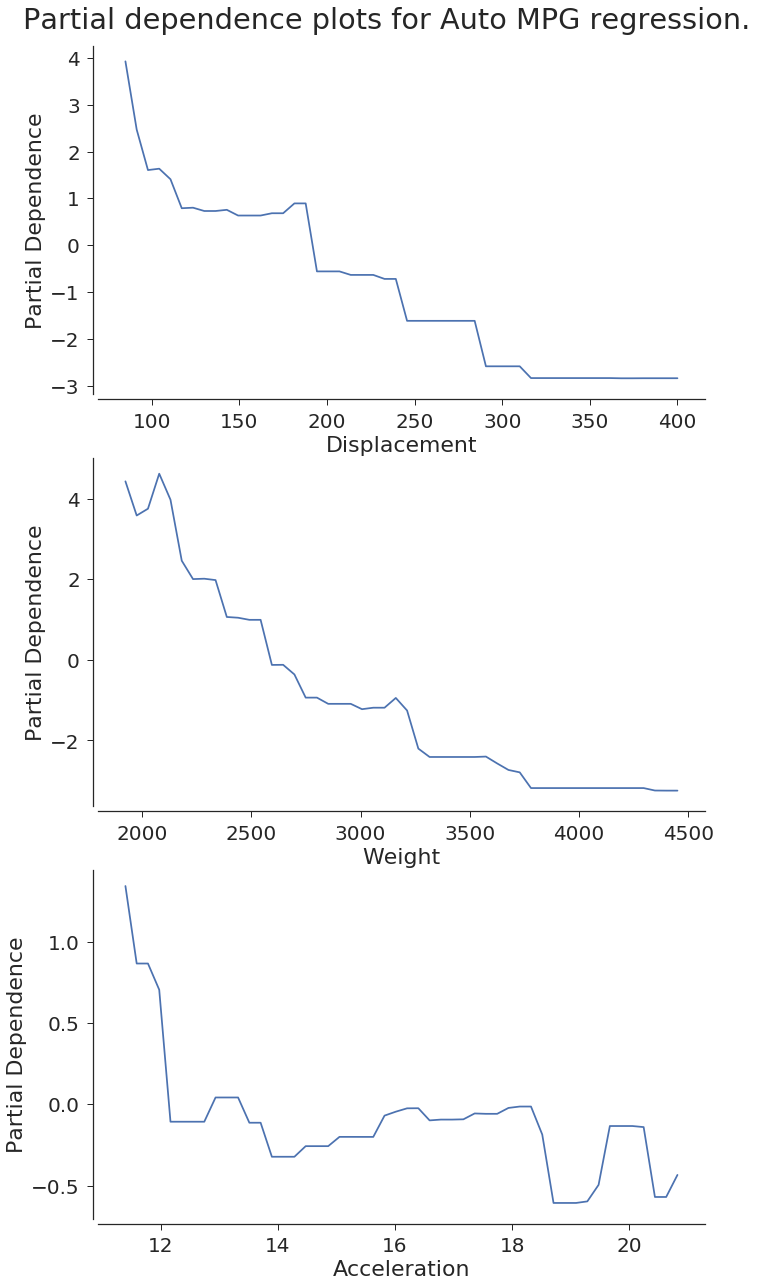

In [20]:
from sklearn.ensemble.partial_dependence import partial_dependence

# The features to display in one-way partial dependence plots
feature_names = ['Displacement', 'Weight', 'Acceleration']

# Make the figure
fig, axs = plt.subplots(figsize=(10, 6 * len(feature_names)), 
                        nrows=len(feature_names), ncols=1, 
                        sharex=False)

# Make the three plots fit nicely in the space.
fig.tight_layout()
fig.subplots_adjust(top=0.95)

# Title the entire figure
fig.suptitle('Partial dependence plots for Auto MPG regression.')

# Iterate over the individual plots
for idx, ax in enumerate(axs):
    
    # Compute the partial dependence between the model and the 
    # specified vairable. We start with index 19 to skip the 
    # categorical features.
    pdp, axd = partial_dependence(auto_model, [19 + idx], 
                                  X=ind_train, grid_resolution=50)
    
    # Plot the data
    ax.plot(axd[0], pdp[0])
    
    # Decorate the plot
    ax.set_xlabel(feature_names[idx])
    ax.set_ylabel('Partial Dependence')
    sns.despine(offset=5)

-----

We can also generate a two-dimensional partial dependence plot for a gradient tree boosting estimator, which shows the relationship between two input features and the target feature, by using the [`plot_partial_dependence`][skppd] function. The following Code cell demonstrates this by using the `Weight` and `Displacement` features. 

The generated figure displays the same information shown in the previous figures, but in this case, we see the relationship between the two input features. There is a strong inverse relationship between these features and the target feature, which starts high in the lower left corner of the plot and decreases moving to the upper right corner. This figure shows the power of partial dependence plots in interpreting relationships between features and the regression model.

-----

[skppd]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.partial_dependence.plot_partial_dependence.html

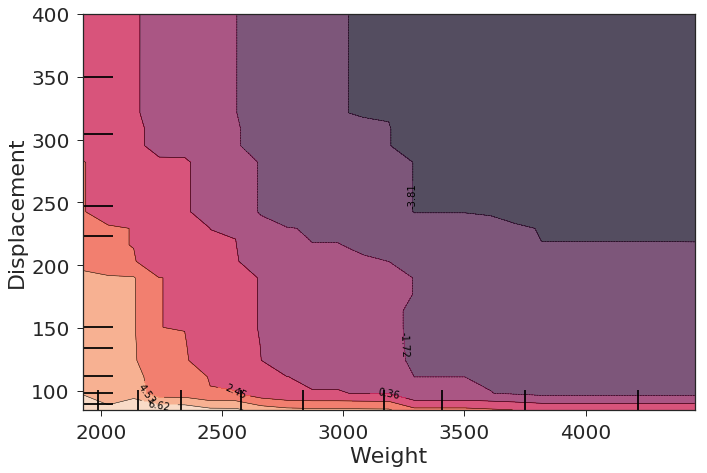

In [21]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence

# Build feature name list, we only care about two, but
# the plot_partial_dependence requires them all, in order
# to match the size of training data used to train GBRT.
# Thus, we make a list of empty strings, then change 
# relevant two entries to make our plot
feature_names = ['' for idx in range(22)]
feature_names[19] = 'Displacement'
feature_names[20] = 'Weight'

# Create figure
fig, axs = plt.subplots(figsize=(10, 10))

# Specify features of interest
fts = [(20, 19)]

# Make the plot
fig, axs = plot_partial_dependence(auto_model, features=fts, 
                                   X=ind_train, ax=axs,
                                   feature_names=feature_names,
                                   grid_resolution=25)

-----

[[Back to TOC]](#Table-of-Contents)

## Adaboost

We now turn our attention to the second boosting algorithm presented in this notebook, [Adaboost][wab], which is short for _Adaptive Boosting_. Adaboost was an early boosting algorithm that iteratively adjusts the weights on the training data to improve the performance of the ensemble algorithm. The weights are adjusted on each iteration to increase the predictive accuracy on the incorrectly predicted training data. This algorithm can be used for both classification and regression and accepts only a handful of hyperparameters:
- `base_estimator`: the base estimator to use for the boosting, by default this is a decision tree.
- `n_estimators`: the maximum number of base estimators to use for boosting, by default this is fifty.
- `learning_rate`: shrinks the impact of each successive iteration on the boosting process.
- `algorithm`: the boosting algorithm to use. Note, this hyperparameter should only be adjusted by more experienced analysts.
- `random_state`: enables reproducibility.

Of these, we will set the `random_state` hyperparameter to enable reproducibility of our results. Both the `n_estimators` and the `learning_rate` hyperparameters can also be easily adjusted to improve performance. The rest of this section applies this algorithm to the Adult data, for classification, and the Auto data, for regression.

-----

[wab]: https://en.wikipedia.org/wiki/AdaBoost

### Classification

To perform classification with the Adaboost algorithm, we use the [`AdaBoostClassifier`][skac] estimator. We demonstrate this in the following two Code cells. In the first Code cell, we create this estimator, using the default values, and fit this estimator to our training data. The second Code cell computes and displays various performance metrics. As with the other ensemble algorithms, the Adaboost classifier provides good classification results, even with no tuning of the hyperparameters.

-----
[skac]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [22]:
from sklearn.ensemble import AdaBoostClassifier

adult_model = AdaBoostClassifier(random_state=23)

adult_model = adult_model.fit(d_train, l_train)

In [23]:
from sklearn import metrics

# Classify test data and display score and report
predicted = adult_model.predict(d_test)
score = 100.0 * metrics.accuracy_score(l_test, predicted)
print(f'Adaboost Classification [Adult Data] Score = {score:4.1f}%\n')
print('Classification Report:\n {0}\n'.format(
    metrics.classification_report(l_test, predicted)))

Adaboost Classification [Adult Data] Score = 86.0%

Classification Report:
              precision    recall  f1-score   support

          0       0.88      0.95      0.91     12298
          1       0.78      0.59      0.67      3983

avg / total       0.85      0.86      0.85     16281




-----

### Regression

To use the Adaboost algorithm to perform regression, we use the [`AdaBoostRegressor`][skar] estimator, which is in the `ensemble` module. This regressor performs single-output regression, which is demonstrated in the following Code cells. First, we create our regressor, using the default hyperparameter values. Next, we fit this model to our training data and compute and display a basic regression score. The second Code cell computes and displays a variety of regression performance metrics, which all confirm this algorithm performs similarly to other ensemble learning algorithms, even with only fifty percent of the data used for training.

-----
[skar]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

In [24]:
from sklearn.ensemble import AdaBoostRegressor

# Create Regressor with default properties
auto_model = AdaBoostRegressor(random_state=23)

# Fit estimator and display score
auto_model = auto_model.fit(ind_train, dep_train)
print('Score = {:.1%}'.format(auto_model.score(ind_test, dep_test)))

Score = 72.9%


In [25]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

# Regress on test data
pred = auto_model.predict(ind_test)

# Compute performance metrics
mae = mean_absolute_error(dep_test, pred)
mse = mean_squared_error(dep_test, pred)
mbe = median_absolute_error(dep_test, pred)
mr2 = r2_score(dep_test, pred)

ev_score = explained_variance_score(dep_test, pred)

# Display metrics
print(f'Mean Absolute Error   = {mae:4.2f}')
print(f'Mean Squared Error    = {mse:4.2f}')
print(f'Median Absolute Error = {mbe:4.2f}')
print(f'R^2 Score             = {mr2:5.3f}')
print(f'Explained Variance    = {ev_score:5.3f}')

Mean Absolute Error   = 2.95
Mean Squared Error    = 15.57
Median Absolute Error = 2.36
R^2 Score             = 0.729
Explained Variance    = 0.742


-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. A discussion on the [Adaboost][2] algorithm from the Machine learning Mastery website
2. An article on [hyperparameter tuning][3] for gradient boosted trees at Analytics Vidhya
12. A guide to using the [XG-Boost][4] algorithm, which is not in the scikit learn library
23. A long [discussion][5] on gradient boosting

-----

[2]: https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/

[3]: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

[4]: https://jessesw.com/XG-Boost/

[5]: http://rcarneva.github.io/understanding-gradient-boosting-part-1.html

**&copy; 2017: Robert J. Brunner at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode